## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.8.0.*, but conda is ignoring the .* and treating it as 1.8.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(6, 7):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:22<00:00,  3.81it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_6"])
layer_hs_array.shape

(10000, 267264)

## Layer 6 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

dim_reduced_vecs = layer_hs_array

# random_projector = GaussianRandomProjection(random_state = 42)
# dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 267264)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 267264)
(8000,)
(2000, 267264)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 267264D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 4.08 s
Outer iteration 0 / 10
  Iteration 19 (11.25 s, search 7.43 s): objective=2054.66 imbalance=1.200 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (22.43 s, search 14.83 s): objective=2056.66 imbalance=1.139 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (33.61 s, search 22.23 s): objective=2053.12 imbalance=1.090 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (44.79 s, search 29.63 s): objective=2056.92 imbalance=1.168 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (55.98 s, search 37.02 s): objective=2048.35 imbalance=1.547 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (67.18 s, search 44.42 s): objective=2052.39 imbalance=1.274 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (78.36 s,

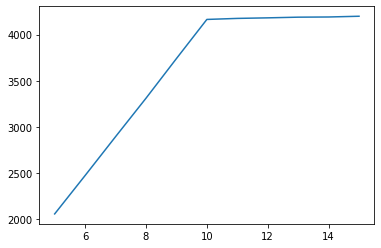

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 267264D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 1.27 s
Outer iteration 0 / 10
  Iteration 19 (22.98 s, search 14.94 s): objective=4139.63 imbalance=1.650 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (46.03 s, search 29.89 s): objective=4155.49 imbalance=1.307 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (69.04 s, search 44.81 s): objective=4146.13 imbalance=1.342 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (92.17 s, search 59.82 s): objective=4157.67 imbalance=1.406 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 10
  Iteration 19 (115.22 s, search 74.76 s): objective=4120.4 imbalance=2.523 nsplit=0        
Outer iteration 5 / 10
  Iteration 19 (138.22 s, search 89.68 s): objective=4133.93 imbalance=1.757 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (161.19 s, search 104.60 s): objective=4160.71 imb

4164.39013671875

In [15]:
kmeans.centroids #cluster centers

array([[-1.9111346e-02,  2.1351352e-02,  8.6700879e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.1132160e-02,  2.3609009e-02,  9.5868548e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.7195243e-02,  1.9210663e-02,  7.8008282e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-1.7973455e-02,  2.0080088e-02,  8.1538772e-03, ...,
         1.6521160e-06,  1.7453472e-06,  8.8428224e-06],
       [-1.7449785e-02,  1.9495029e-02,  7.9163071e-03, ...,
        -1.2428680e-05,  2.3821083e-05, -3.9882948e-06],
       [-2.1297082e-02,  2.3793273e-02,  9.6616801e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000182
1.0000062
1.0000232
1.0000066
1.0000161
1.000007
1.0000051
1.0000286
1.0000129
1.0000086


In [17]:
kmeans.obj #inertia at each iteration

array([2557.33862305, 3968.10522461, 4069.87060547, 4111.54296875,
       4125.41503906, 4132.62646484, 4135.91650391, 4136.85107422,
       4137.15722656, 4137.31884766, 4137.45410156, 4137.55322266,
       4137.68359375, 4137.89111328, 4138.24707031, 4138.86279297,
       4139.26220703, 4139.34423828, 4139.41015625, 4139.62744141,
       2561.96386719, 3963.140625  , 4069.57495117, 4119.98730469,
       4134.60888672, 4143.21533203, 4147.04052734, 4147.92675781,
       4148.60644531, 4149.35742188, 4150.85058594, 4153.57373047,
       4155.25683594, 4155.421875  , 4155.46386719, 4155.47607422,
       4155.48339844, 4155.48535156, 4155.48535156, 4155.48535156,
       2480.39160156, 3974.8527832 , 4082.35644531, 4112.91748047,
       4124.75537109, 4135.4296875 , 4140.68798828, 4142.24853516,
       4143.23632812, 4144.15234375, 4144.79541016, 4145.13525391,
       4145.31933594, 4145.47998047, 4145.62744141, 4145.76904297,
       4145.87402344, 4145.98583984, 4146.05810547, 4146.12890

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

4    1403
0    1368
6    1055
5    1043
8     851
3     820
9     448
2     341
7     337
1     334
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[6, 10, 9, 5, 4, 6, 1, 3, 10, 3]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 6, 1: 10, 2: 9, 3: 5, 4: 4, 5: 6, 6: 1, 7: 3, 8: 10, 9: 3}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 6,  9,  9, ...,  6, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.31375
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.98125
Prompt 4 Accuracy:  0.34125
Prompt 5 Accuracy:  0.415
Prompt 6 Accuracy:  0.56875
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.2175
Prompt 10 Accuracy:  0.81


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.36475


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

0    347
4    346
6    281
5    248
3    208
8    194
9    106
2    104
7     88
1     78
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 1,  9,  6, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.33
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.97
Prompt 4 Accuracy:  0.35
Prompt 5 Accuracy:  0.455
Prompt 6 Accuracy:  0.535
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.275
Prompt 10 Accuracy:  0.825


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.374


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

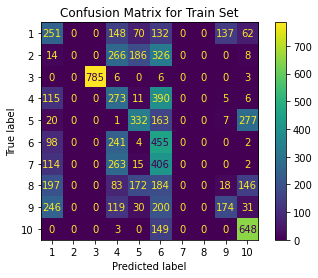

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

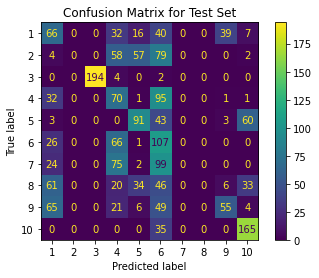

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()